In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import img_to_array, to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout

In [4]:
DATA_PATH = r'C:\Users\shail\Desktop\NSL\NSL RGB'

In [5]:
categories = sorted(os.listdir(DATA_PATH))
print(f"Categories: {categories}")

Categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
# load images with their labels and resize images to 224 X 224 pixels.
def load_images_and_labels(data_path, categories, img_size=(224, 224)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(category)  
    return np.array(images, dtype=np.float16), np.array(labels)

images, labels = load_images_and_labels(DATA_PATH, categories)

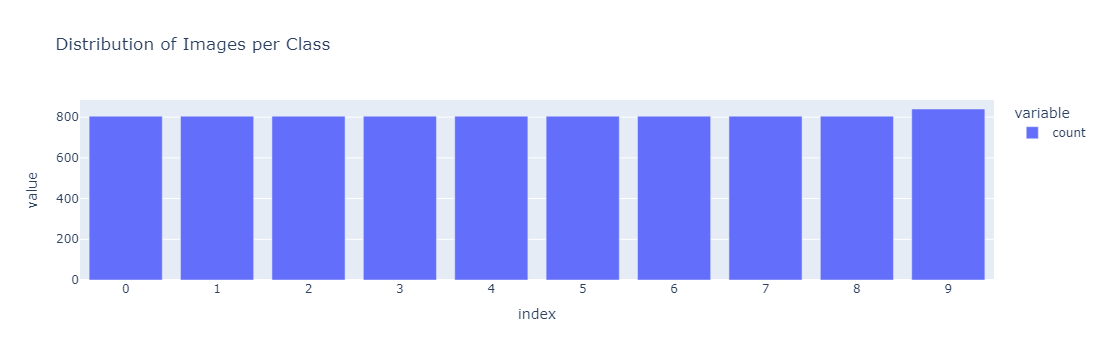

In [39]:
# Plot distribution of images per class
label_counts = pd.Series(labels).value_counts().sort_index()
fig = px.bar(label_counts, title="Distribution of Images per Class")
fig.show()

In [7]:
print(np.unique(labels))

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [8]:
# encode the labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)


one_hot_labels = to_categorical(integer_encoded)


print("One-Hot Encoding Output:")
print(f"Original Label: {labels[0]} - Encoded: {one_hot_labels[0]}")
print(f"Original Label: {labels[-1]} - Encoded: {one_hot_labels[-1]}")

One-Hot Encoding Output:
Original Label: 0 - Encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original Label: 9 - Encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


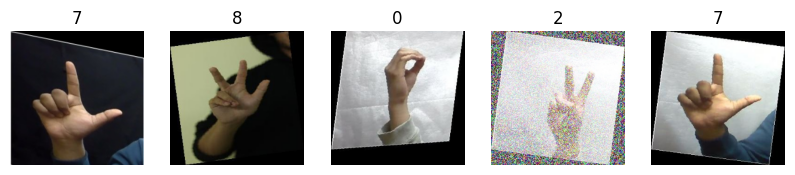

In [18]:
# function display images
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    
    indices = random.sample(range(len(images)), num_images)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].astype("uint8")) 
        plt.title(labels[idx])  
        plt.axis('off')  
    
    plt.show()

display_images(images, labels, num_images=5)

In [19]:
# Split the dataset
X_train, X_test, y_labels, y_test_labels = train_test_split(
    images, 
    one_hot_labels, 
    test_size=0.3, 
    random_state=42, 
    shuffle=True, 
    stratify=one_hot_labels
)

LOADING PRETRAINED MODEL VGG16

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [52]:
X_train[0].shape

(224, 224, 3)

In [23]:
# preprocess the images for finetuning VGG16 pretrained
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

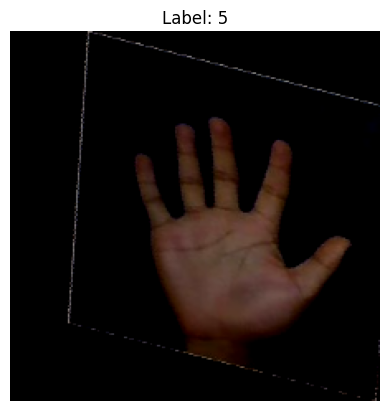

In [62]:
# Display the preprocessed images VGG16 format
image_index = 9  
image_to_display = X_train[image_index]

# reverse the normalization for VGG16 to display
image_to_display = image_to_display + np.array([123.68, 116.779, 103.939])
image_to_display = np.clip(image_to_display, 0, 255).astype(np.uint8)

# Decode the corresponding label from the training labels
decoded_label = np.argmax(y_labels[image_index])  


plt.imshow(image_to_display)
plt.axis('off')  
plt.title(f"Label: {decoded_label}") 
plt.show()

In [63]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=X_train[0].shape)

In [64]:
base_model.trainable = False

In [65]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

CUSTOM OUTPUT LAYERS

In [73]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(len(categories), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


In [76]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

initial_learning_rate = 0.001

optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.2,            
    patience=5,           
    min_lr=1e-6            
)


early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    verbose=1,
    mode=max,
    restore_best_weights=True
)


C:\Users\shail\AppData\Local\Temp\ipykernel_9228\3229762160.py:18: UserWarning:

EarlyStopping mode <built-in function max> is unknown, fallback to auto mode.



In [78]:
history = model.fit(
    X_train, y_labels,
    validation_data=(X_test, y_test_labels),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1833s 10s/step - accuracy: 0.2217 - loss: 3.2493 - val_accuracy: 0.6892 - val_loss: 1.4536 - learning_rate: 0.0010
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1901s 11s/step - accuracy: 0.5477 - loss: 1.7881 - val_accuracy: 0.7997 - val_loss: 1.1326 - learning_rate: 0.0010
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1916s 11s/step - accuracy: 0.6714 - loss: 1.4228 - val_accuracy: 0.8524 - val_loss: 0.9909 - learning_rate: 0.0010
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1911s 11s/step - accuracy: 0.7253 - loss: 1.2410 - val_accuracy: 0.8685 - val_loss: 0.9099 - learning_rate: 0.0010
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1888s 11s/step - accuracy: 0.7847 - loss: 1.0967 - val_accuracy: 0.8747 - val_loss: 0.8586 - learning_rate: 0.0010
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1875s 11s/step - accuracy: 0.8157 - loss: 1.0017 - val_accuracy: 0.8817 - val_loss: 0.8079 - learning_rate: 0.0010
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1869s 11s/step - accuracy: 0.8

In [79]:
model.save('_pretrained_vgg16.keras')

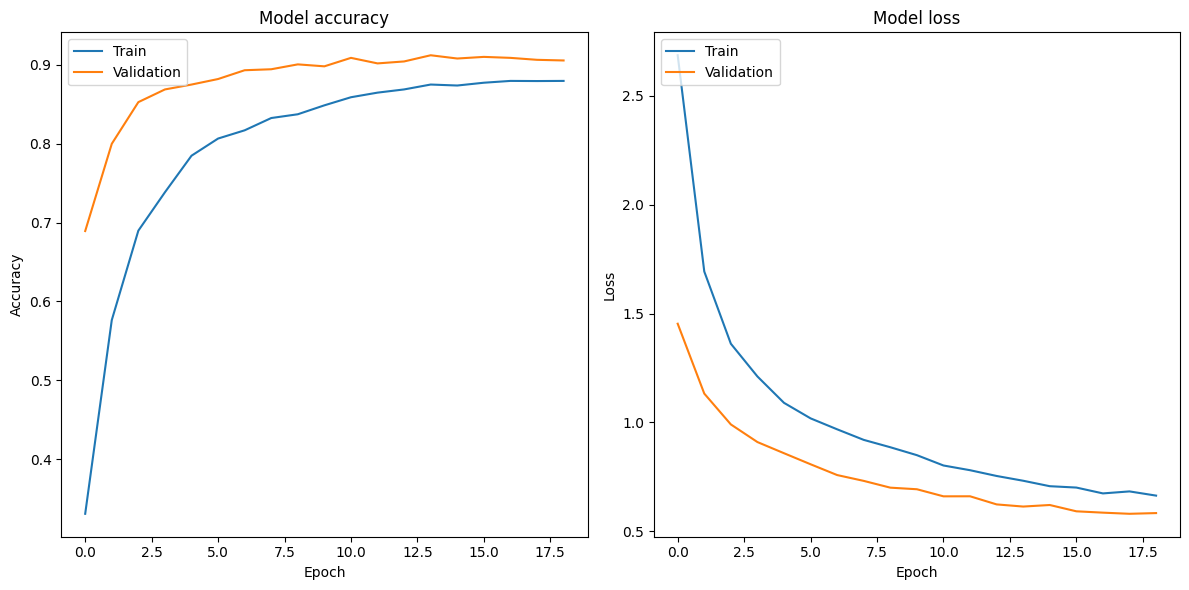

In [80]:
# plotting validation and training accuracy/loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


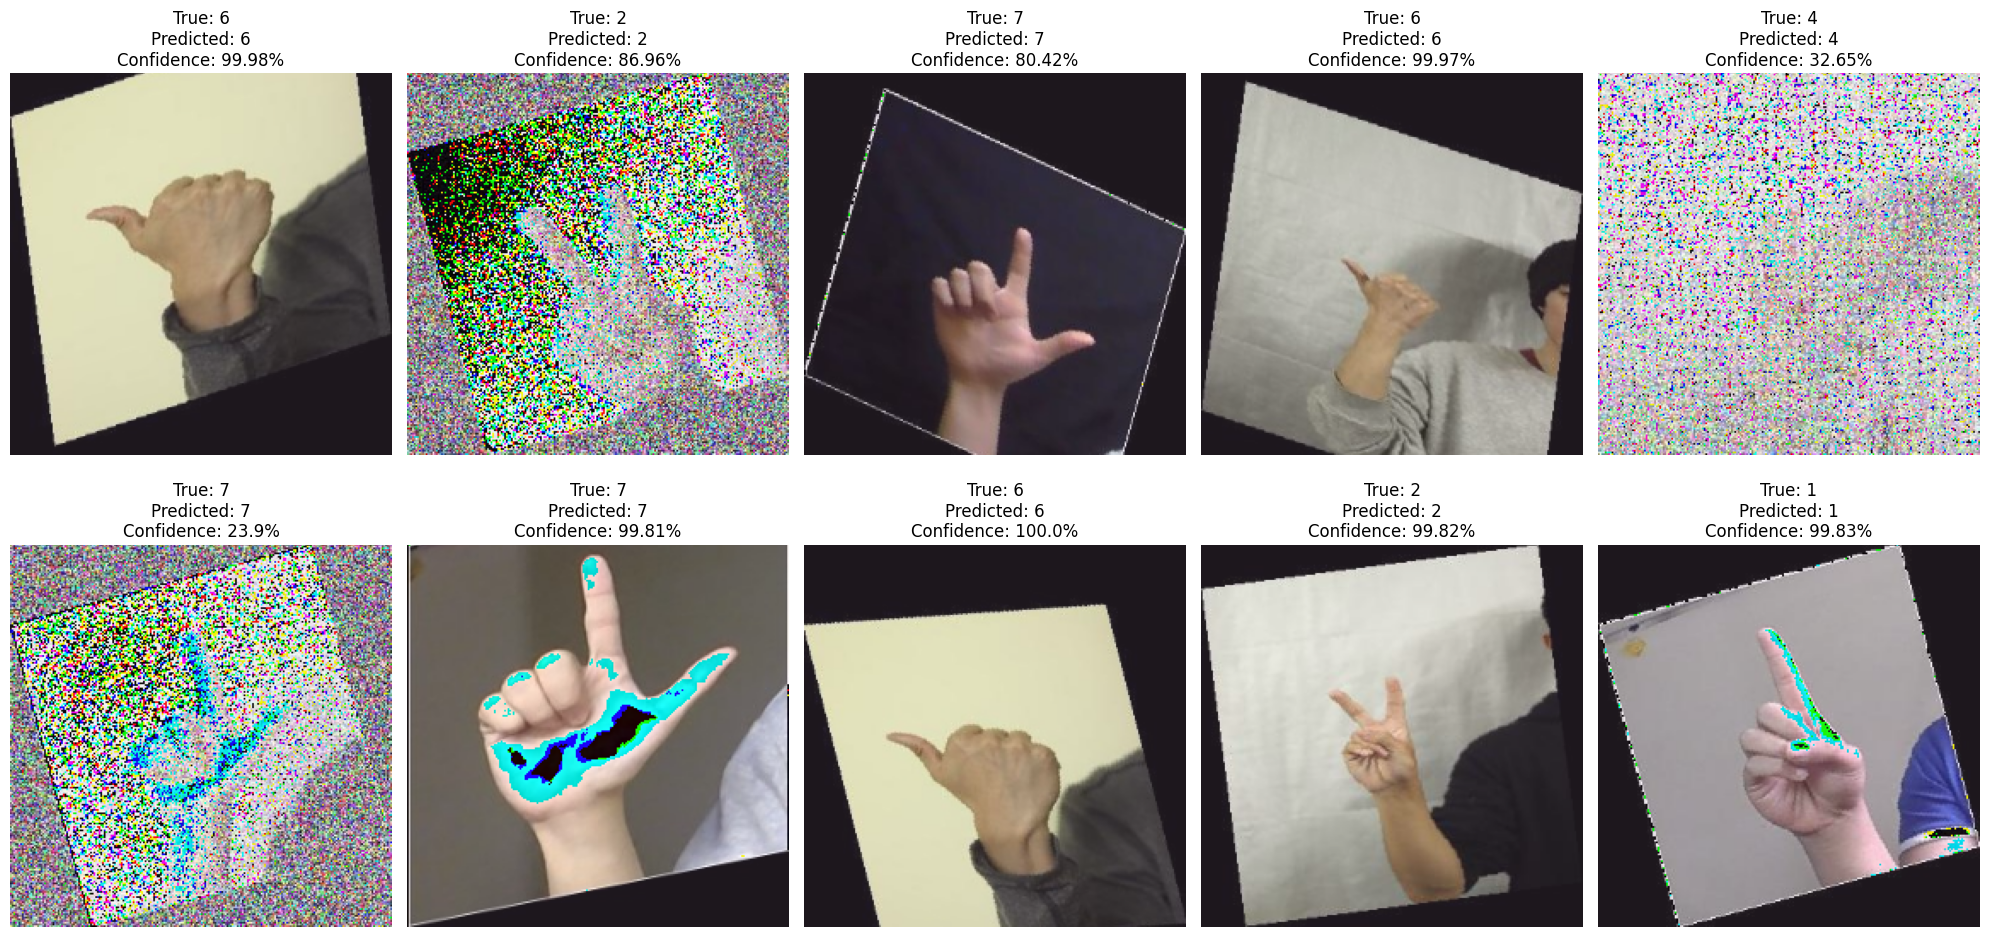

In [84]:

def display_predictions(model, X_test, y_test_labels, class_names, num_images=10):

    random_indices = np.random.choice(len(X_test), size=num_images, replace=False)

    
    plt.figure(figsize=(20, 10))  

    for i, index in enumerate(random_indices):
     
        image = X_test[index]
        true_label = y_test_labels[index]

      
        img_array = np.expand_dims(image, axis=0) 
        predictions = model.predict(img_array)

   
        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * np.max(predictions[0]), 2)

   
        plt.subplot(2, 5, i + 1) 
        plt.axis('off')
        plt.imshow(image.astype('uint8')) 
        plt.title(f"True: {class_names[np.argmax(true_label)]}\nPredicted: {predicted_class}\nConfidence: {confidence}%")

    plt.tight_layout()  
    plt.show()


display_predictions(model, X_test, y_test_labels, label_encoder.classes_, num_images=10)


In [ ]:
model = load_model('_pretrained_vgg16.keras')

y_pred = model.predict(X_test) 
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true_classes = np.argmax(y_test_labels, axis=1)  

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       242
           1       0.61      0.73      0.67       241
           2       0.53      0.51      0.52       242
           3       0.70      0.20      0.32       241
           4       0.45      0.76      0.56       242
           5       0.43      0.69      0.53       242
           6       0.77      0.76      0.77       242
           7       0.65      0.62      0.63       241
           8       0.60      0.27      0.38       241
           9       0.52      0.44      0.47       252

    accuracy                           0.58      2426
   macro avg       0.61      0.58      0.57      2426
weighted avg       0.61      0.58      0.57      2426



<Figure size 1000x700 with 0 Axes>

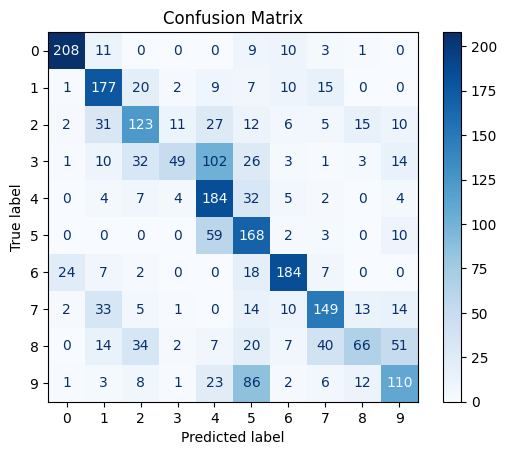

In [26]:
cm = confusion_matrix(y_true_classes, y_pred_classes)


report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)


print("Classification Report:")
print(report)

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
